<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/3mnist-multilayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/3mnist-multilayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A deep feedforward network with arbitrary depth

In this exercise we build a deep feedforward neural network to recognize handwrittne digits (the MNIST data). The code has many tweekable parameters, in particular the number and width of layers. But as you will see adding more layers slows down the convergence considerably.


The usual imports plus gzip and pickle to read the data

In [1]:
#import numpy as np
import cupy as np
import matplotlib.pyplot as plt
import random
#import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers

Important to be able to diplay matplotlib plots inline in the notebook

In [2]:
%matplotlib inline

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

The data are in compressed pickle format. 

In [4]:
def load_dataset():
  # tensorflow assumes the input and output are row vectors
  # where as in our implementation we use them as column vectors
    tr,te=keras.datasets.mnist.load_data()
    X=tr[0].astype("float32")/255
    Y=tr[1]
    Y=Y.reshape(1,len(Y))
    V=np.zeros((10,Y.shape[1]))
    for j in range(Y.shape[1]):
        V[Y[0,j],j]=1
        
    Y=V.astype("float32")
    test_data=te[0].astype("float32")/255
    test_labels=te[1].astype("float32")
    test_labels=test_labels.reshape(1,len(test_labels))
    return X,Y.T,test_data,test_labels.T


In [5]:
X, Y,test_data,test_labels = load_dataset()
print(X.shape)
print(Y.shape)
print(test_data.shape)
print(test_labels.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 10)
(10000, 28, 28)
(10000, 1)


The activation function is sigmoid

In [6]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

This function plots some of the misclassified data in order for us to have an idea what when wrong.

In [47]:
def print_misclassified(test_data,test_labels,biases,weights):
    As=forward_propagation(test_data,biases,weights)
    output=As[-1]
    count=0
    fig=plt.figure()
    fig.tight_layout()
    plt.subplots_adjust( wspace=1, hspace=1)

    for i in range(output.shape[0]):
        label=np.argmax(output[i,:])
        if label != test_labels[i,0]:
            if count>40:
                break
            subfig=count%40+1
            count=count+1
            img=np.asnumpy(test_data[i,:]).reshape(28,28)
            t=fig.add_subplot(4,10,subfig)
            #t.set_title(str(i))
            t.set_title(str(label))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img,cmap='gray_r')



Returns the number of correct predictions. Note that the output of our model is in one-hot encoding so it has 10 rows and N columns where is the number of data points whereas test_labels is NOT in one-hot encoding so it has a single row and N columns. For a given column i argmax returns the row index which has the largest value, i.e. the largest likelyhood


In [8]:
def evaluate(test_data,biases,weights):
    As=forward_propagation(test_data,biases,weights)
    output=As[-1]
    count=0
    #the output is in one-hot encoding so it has 10 rows
    # and number of data columns where as test_tables 
    # is NOT in one-hot encoding so it has a single row
    for i in range(output.shape[0]):
        if np.argmax(output[i,:])==test_labels[i,0]:
            count=count+1
    return count

The usual cross Entropy cost. Unlike the evaluate function both the "true" labels and the output of our model are in one-hot encoding

In [9]:
def compute_cost(Y,b,w):
    
    m = Y.shape[0] # number of example

    # Compute the cross-entropy cost
    As=forward_propagation(X,b,w)
    # recall that As contains the "output" of all layers
    # including the input As[0] and the final output As[-1]
    output=As[-1]
    logprobs = np.log(output)*Y+np.log(1-output)*(1-Y)
    cost = -np.sum(logprobs)/m

    count=0
    for i in range(output.shape[0]):
        if (np.argmax(output[i,:])==np.argmax(Y[i,:])):
            count=count+1

    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    #assert(isinstance(cost, float))
    
    return cost,count


The weights are initialized randomly and the biases are initially set to zero

In [10]:
def initialize_parameters(width):    
    weights=[]
    biases=[]
    for i in range(len(width)-1):
        w=np.random.randn(width[i],width[i+1])
        b=np.zeros((width[i+1],))
        weights.append(w)
        biases.append(b)

    return biases,weights


Forward propagation over all the layers but also retain the intermediate results.
For example below As[0] is the input, As[1] is the output of the first layer,..., and As[-1] (the last) is the output

In [11]:
def forward_propagation(X,biases,weights):
    a=X
    As=[X]
    for w,b in zip(weights,biases):
       z=np.dot(a,w)+b
       a=sigmoid(z)
       As.append(a)

    return As

## Backpropagation

\begin{align*}
\Delta^l_{mn}&=\sum_k \Delta^{l+1}_{mk}W^l_{nk}\theta^l_{mn}\\
dW_{ij}&=\frac{1}{m}\sum_m\Delta^{l+1}_{mj}A^l_{mi}
\end{align*}

Or in matrix notation
\begin{align*}
\Delta^l&=\Delta^{l+1}\cdot (W^l)^T\theta^l\\
dW^l&=\frac{1}{m}(A^l)^T\cdot \Delta^{l+1}
\end{align*}

In [12]:
def backward_propagation(X,Y,biases,weights):
    
    As=forward_propagation(X,biases,weights)
    m = X.shape[0]
    
    nlayers=len(biases)
    # Error of the last layer
    dz=As[nlayers]-Y

    gradb=[]
    gradw=[]
    for i in range(nlayers,0,-1):
        db=np.sum(dz,axis=0,keepdims=True)/m
        dw=np.dot(As[i-1].T,dz)/m
        dz=np.dot(dz,weights[i-1].T)*As[i-1]*(1-As[i-1])
        gradb.insert(0,db)
        gradw.insert(0,dw)
    
    return gradb,gradw

In [13]:
def update_parameters(biases,weights, gradb,gradw, learning_rate):


    for i in range(len(biases)):
        weights[i]=weights[i]-learning_rate*gradw[i]
        biases[i]=biases[i]-learning_rate*gradb[i]

    return biases,weights

Initialize the parameters


In [14]:
def GD(X, Y, test_data,width,batch_size,num_iterations, learning_rate,print_cost=False):

    #n_x=X.shape[0]
    #n_y=Y.shape[0]
    biases,weights=initialize_parameters(width)
    
    for i in range(0, num_iterations):
        cost,count = compute_cost(Y,biases,weights)
        for k in range(0,X.shape[0],batch_size):
            idx=[random.randint(0,Y.shape[0]-1) for s in range(batch_size)]
            yb=Y[idx,:]
            xb=X[idx,:]
            gradb,gradw=backward_propagation(xb,yb,biases,weights)
            biases,weights=update_parameters(biases,weights,gradb,gradw,learning_rate)    

        if i%1 ==0 : 
            print(len(weights))   
            count_test=evaluate(test_data,biases,weights)
            print ("Cost after iteration %i: %f" %(i, cost))
            print("count after iteration %i is %i" %(i,count))
            print("test count after iteration %i is %i" %(i,count_test))
    return biases,weights

In [15]:
X, Y,test_data,test_labels = load_dataset()
X=np.array(X.reshape(60000,784))
test_data=np.array(test_data.reshape(10000,784))

n_x=X.shape[1]
n_y=Y.shape[1]
width=[n_x,128,64,n_y]
biases,weights= GD(X, Y,test_data,width,batch_size=512,learning_rate=3,
                num_iterations =10, print_cost=True)


count=evaluate(test_data,biases,weights)
A=forward_propagation(X,biases,weights)



3
Cost after iteration 0: 16.655688
count after iteration 0 is 6795
test count after iteration 0 is 8113
3
Cost after iteration 1: 1.115907
count after iteration 1 is 48264
test count after iteration 1 is 8967
3
Cost after iteration 2: 0.666167
count after iteration 2 is 53636
test count after iteration 2 is 9101
3
Cost after iteration 3: 0.556803
count after iteration 3 is 54742
test count after iteration 3 is 9204
3
Cost after iteration 4: 0.483412
count after iteration 4 is 55533
test count after iteration 4 is 9273
3
Cost after iteration 5: 0.426521
count after iteration 5 is 56025
test count after iteration 5 is 9314
3
Cost after iteration 6: 0.379309
count after iteration 6 is 56500
test count after iteration 6 is 9337
3
Cost after iteration 7: 0.354676
count after iteration 7 is 56758
test count after iteration 7 is 9368
3
Cost after iteration 8: 0.326506
count after iteration 8 is 57025
test count after iteration 8 is 9369
3
Cost after iteration 9: 0.311267
count after iteratio

Prints some of the misclassified digits. The top on each digit shows the (wrong) prediction.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


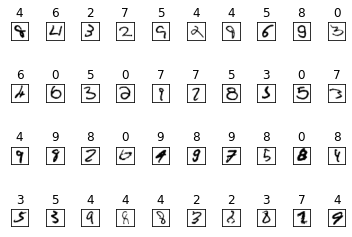

In [48]:
print_misclassified(test_data,test_labels,biases,weights)
